# In-Depth Analysis 

## Loading Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 

## Importing the data

In [2]:
recipes_df=pd.read_csv('recipes_df.csv')
recipes_df.set_index('id', inplace=True)
reviews_df=pd.read_csv('reviews_df.csv')
reviews_df.set_index('recipe_id', inplace=True)
tags_matrix=pd.read_csv('tags_matrix.csv')
tags_matrix.set_index('id', inplace=True)
ingredients_matrix=pd.read_csv('ingredients_matrix.csv')
ingredients_matrix.set_index('id', inplace=True)

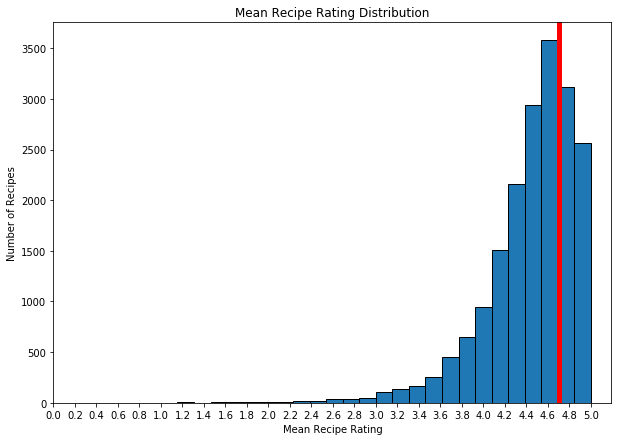

In [3]:
avg_rating_series=reviews_df.groupby('recipe_id')['rating'].mean()
_ = plt.figure(figsize=(10,7))
x_range=[0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,
         2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,
         4.0,4.2,4.4,4.6,4.8,5.0]
_ = plt.hist(avg_rating_series, edgecolor='black', bins=25)#(len(x_range)-1)#np.arange(, 5, 0.20))
_ = plt.title('Mean Recipe Rating Distribution')
_ = plt.xlabel('Mean Recipe Rating')
_ = plt.ylabel('Number of Recipes')
_ = plt.xticks(x_range)
_ = plt.axvline(x=4.7, linewidth=5, color='r')

Based on the histogram above we decided to arbitrarily choose a mean rating of 4.7 as a threshold for "good" vs "bad" recipes.

In [4]:
print('Number of "good" recipes with rating >=4.7 = '
      +str(len(avg_rating_series.index[avg_rating_series.values>=4.7]))+'\n'
      +'Number of "bad" recipes with rating < 4.7 = '
      +str(len(avg_rating_series.index[avg_rating_series.values<=4.7])))

Number of "good" recipes with rating >=4.7 = 5519
Number of "bad" recipes with rating < 4.7 = 13302


## Random Forest

First, we need to create a combined_df containing all the features in one dataset.

In [5]:
combined_df=recipes_df[['minutes','n_steps','Calories','Total Fat','Sugars',
           'Sodium','Protein','Saturated Fat',
            'Total Carbohydrate']].merge(ingredients_matrix, right_index=True,left_index=True)
combined_df=combined_df.merge(tags_matrix,right_index=True,left_index=True)
combined_df=combined_df.join(avg_rating_series, how='left')
combined_df.head(3)

,minutes,n_steps,Calories,Total Fat,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate,flour,...,'spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,500,5,105.7,8.0,0.0,26.0,5.0,4.0,3.0,1,...,0,0,0,0,0,0,0,0,0,4.368421
43026,45,9,94.0,10.0,0.0,11.0,11.0,21.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4.045455
23933,15,4,232.7,21.0,77.0,4.0,6.0,38.0,8.0,0,...,0,0,0,0,0,0,0,0,0,4.833333


We have data with 653 features. We use a Random Forest classifier on the dataset to classify the recipes as "good" (e.g. average rating >= 4.7) or "bad".

In [6]:
combined_df['rating1'] = combined_df.rating.apply(lambda x: 1 if x >= 4.7 else 0)

In [7]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X=combined_df.iloc[:,:-2].values
y=combined_df.rating1.values.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42)

y_pred = rf.fit(X_train,y_train).predict(X_test)

### Tuning in Hyperparameters

Let's tune in the hyperparameters for the Random Forest model:
- n_estimators (default is 10 in our version of sklearn). 
- max_depth (default=None) The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split (default=2) The minimum number of samples required to split an internal node
- min_samples_leaf (default=1) The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- min_weight_fraction_leaf (default=0.) The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- max_features (default=”auto”) The number of features to consider when looking for the best split 

<br> We will use GridSearch to tune in multiple parameters at a time, and will use ROC_AUC score as our accuracy metric.

In [8]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 50, 100]
             ,'max_depth': [3, 7, 11]
             ,'min_samples_split': [2, 5]
             ,'min_samples_leaf': [1, 3]
             ,'min_weight_fraction_leaf': [0, 0.25]
             ,'max_features': [5, 10, 20]} 

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc') 
rf_cv.fit(X, y) 
rf_cv.best_params_

{'max_depth': 11,
 'max_features': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 100}

In [9]:
rf_cv.best_score_

0.616874177613216

The best combination of parameters produces the best average score of all cv folds equal to 62% with Random Forest classifier model.

### Feature Importances

Let's review top 20 most important features by using sklearn feature_importances_

In [10]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

rf.fit(X, y) 
zipped = zip(combined_df.iloc[:,:-2].columns,rf.feature_importances_)
res = sorted(zipped, key = lambda x: x[1], reverse=True)
for i in res[0:20]:
    print(res.index(i), i)

0 ('Calories', 0.03511316443674291)
1 ('Sugars', 0.0324596393875997)
2 ('Sodium', 0.03141175311372838)
3 ('Saturated Fat', 0.031217452029162818)
4 ('Protein', 0.030957616831073464)
5 ('minutes', 0.030385956463672464)
6 ('Total Fat', 0.029885634005539796)
7 ('Total Carbohydrate', 0.029495388759097924)
8 ('n_steps', 0.027769931050696882)
9 ("'60-minutes-or-less'", 0.006835226566435097)
10 (" 'occasion'", 0.006784489883286476)
11 (" 'cuisine'", 0.006711281188137368)
12 (" 'easy'", 0.006628297743010018)
13 ('salt', 0.0062234124509132505)
14 (" 'number-of-servings'", 0.006115122012373905)
15 (" 'taste-mood'", 0.006080912813724839)
16 (" 'equipment'", 0.005533635678412797)
17 (" 'dinner-party'", 0.005482007310521895)
18 (" 'holiday-event'", 0.005472445704097876)
19 ('garlic', 0.005326606002725216)


We can see that all nutritional values and time to cook the recipe ("minutes", "steps", "easy", "60-minutes-or-less") are in the top 20 most important features to predict the goodness of the recipe average rating. Let's rerun Random Forest model with best features only to see if we can get a score improvement.

In [11]:
# create a list of best features to use in column selection
best_features=[]
for i in range(20):
    best_features.append(res[i][0])
# from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
X=combined_df.filter(best_features, axis=1).values
y=combined_df.rating1.values.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42)

y_pred = rf1.fit(X_train,y_train).predict(X_test)

In [12]:
# tuning in hyperparameters:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 50, 100]
             ,'max_depth': [3, 7, 11]
             ,'min_samples_split': [2, 5]
             ,'min_samples_leaf': [1, 3]
             ,'min_weight_fraction_leaf': [0, 0.25]
             ,'max_features': [5, 10, 20]} 

rf1_cv = GridSearchCV(rf1, param_grid, cv=5, scoring='roc_auc') 
rf1_cv.fit(X, y) 
rf1_cv.best_params_

{'max_depth': 11,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 100}

In [13]:
rf1_cv.best_score_

0.5709491675780951

With only the best 20 features and tuned in hyperparameters the Random Forest model ROC_AUC score actually went down from 62% to 57%.

## Logistic Regression 

Let's use a Logistic Regression to predict recipe rating being 'good' or 'bad'

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

X=combined_df.iloc[:,:-2].values
y=combined_df.rating1.values.astype(np.int)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
logreg = LogisticRegression(solver='lbfgs')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

### Tuning in Hyperparameters

Let's tune in hyperparameters for the Logistic regression model:
- C Inverse of regularization strength (Like in support vector machines, smaller values specify stronger regularization.)
- class_weight Weights associated with classes (the default is None) We will try "balanced", e.g. uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data )

In [15]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

logreg = LogisticRegression(solver='lbfgs')
param_grid= {'C': np.logspace(-5, 8, 15)
             ,'class_weight': [None,'balanced']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
logreg_cv.fit(X,y)
logreg_cv.best_params_

{'C': 163789.3706954068, 'class_weight': None}

In [16]:
logreg_cv.best_score_

0.544210926127887

The best average score of all cv folds for the Logistic Regression model is 53%

## K Nearest Neighbours

Let's use KNN to predict recipe rating being 'good' or 'bad'

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
knn = KNeighborsClassifier()
X=combined_df.iloc[:,:-2].values
y=combined_df.rating1.values.astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

### Tuning in Hyperparameters

Let's tune in hyperparameters for the Logistic regression model:
- n_neighbors Number of neighbors to use by the KNN algorithm (default=5)
- weights Weight function used in prediction (default = 'uniform', e.g. all points in each neighborhood are weighted equally) We will choose between 'uniform' and 'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [18]:
knn = KNeighborsClassifier()
param_grid= {'n_neighbors': [5,7,10,20]
             ,'weights': ['uniform','distance']}
knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X,y)
knn_cv.best_params_

{'n_neighbors': 20, 'weights': 'distance'}

In [19]:
knn_cv.best_score_

0.5389189514679892

The best average score of all cv folds for the K Nearest Neighbours model is 53%

## Best Model

In [20]:
d = {'Best Score': [rf_cv.best_score_,rf1_cv.best_score_, logreg_cv.best_score_,knn_cv.best_score_]
     , 'Best Parameters': [rf_cv.best_params_, rf1_cv.best_params_, logreg_cv.best_params_,knn_cv.best_params_]}
models_summary = pd.DataFrame(data=d, index=['Random Forest','Random Forest with 20 Best Features','Logistic Regression','KNN'])
models_summary

,Best Score,Best Parameters
Random Forest,0.616874,"{'max_depth': 11, 'max_features': 20, 'min_sam..."
Random Forest with 20 Best Features,0.570949,"{'max_depth': 11, 'max_features': 5, 'min_samp..."
Logistic Regression,0.544211,"{'C': 163789.3706954068, 'class_weight': None}"
KNN,0.538919,"{'n_neighbors': 20, 'weights': 'distance'}"


The best ROC_AUC score is for the Random Forest model (61%), so this is the best model to predict the average recipe rating being good or bad.

## Thresholding

Let's loop over a list of thresholds from 0 to 1, and at each threshold transform those probabilites into 1s and 0s, and then use our ultimate metric (F-beta score with beta < 1 to be weighted towards precision) to get a score, and pick the threshold that maximizes that metric.

In [21]:
y_pred = rf.fit(X_train,y_train).predict(X_test)
rf_probs=rf.predict_proba(X_test)
rf_probs

array([[0.8, 0.2],
       [0.6, 0.4],
       [0.7, 0.3],
       ...,
       [0.6, 0.4],
       [0.9, 0.1],
       [0.7, 0.3]])

A chart above shows probabi;ity thresholds on X axis, F-beta score on Y axis, and a vertical red line through the optimal threshold of 0.8.

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, best_y_pred))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83      5269
           1       0.69      0.00      0.01      2236

    accuracy                           0.70      7505
   macro avg       0.70      0.50      0.42      7505
weighted avg       0.70      0.70      0.58      7505



C:\Users\anna_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best probability threshold for the model is 0.8.
It maximizes F-beta score to 0.6806694092380289


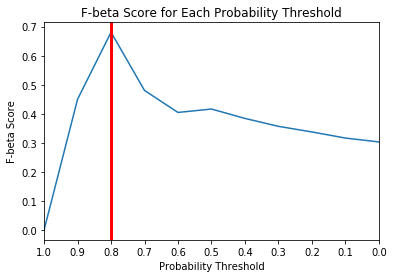

In [38]:
from sklearn.metrics import fbeta_score
#threshold_list = np.arange(0,1.01,0.01)
best_threshold = 0
best_score=0
y_pred_prob = rf.predict_proba(X_test)[:,1]
threshold_list=sorted(list(set(y_pred_prob)))
fbeta_list=[]
for i in threshold_list:
    y_pred=(y_pred_prob > i)*1.0
    test_score = fbeta_score(y_test, y_pred, beta=0.01)
    fbeta_list.append(test_score)
    if test_score>best_score:
        best_threshold = i
        best_score = test_score
        best_y_pred=y_pred
print('Best probability threshold for the model is {0}.\nIt maximizes F-beta score to {1}'.format(best_threshold,best_score))

_ = plt.plot(threshold_list,fbeta_list)
_ = plt.title('F-beta Score for Each Probability Threshold')
_ = plt.xlabel('Probability Threshold')
_ = plt.ylabel('F-beta Score')
_ = plt.xlim(1,0)
_ = plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
_ = plt.axvline(x=best_threshold, linewidth=3, color='r')